# Molecular D-HNN — Chapter 1: Normal Mode Latent Dynamics

**Goal:** Learn interpretable molecular dynamics by projecting into normal-mode coordinates and modelling the latent evolution with a Dissipative Hamiltonian Neural Network.

**Pipeline:**  rMD17 → SchNet (differentiable potential) → Hessian → Normal Modes → D-HNN dynamics

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os, sys

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), "src"))

from dhnn.molecular.datasets import get_rmd17, RMD17_MOLECULES
from dhnn.molecular.copresheaf import CopresheafHamiltonian
from dhnn.molecular.training_mol import train_schnet
from dhnn.molecular.normal_modes import (
    normal_mode_analysis, project_to_modes, project_from_modes,
)
from dhnn.plotting import thesis_viridial, C

plt.style.use(os.path.join(os.path.dirname(os.getcwd()), "Thesis_style.mplstyle"))
torch.manual_seed(42)
np.random.seed(42)

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Device: {DEVICE}")
print(f"Available molecules: {list(RMD17_MOLECULES.keys())}")

Device: mps
Available molecules: ['ethanol', 'aspirin', 'toluene', 'benzene', 'uracil', 'naphthalene', 'salicylic', 'malonaldehyde', 'paracetamol']


---
## 1. Data — rMD17 Ethanol

9 atoms (C₂H₅OH), 100 000 DFT configurations.  Following the standard rMD17 protocol we use 1 000 training samples.

In [2]:
splits = get_rmd17(
    "ethanol",
    n_train=1_000,
    n_val=1_000,
    cutoff=5.0,
    batch_size=32,
)

print(f"Molecule:   ethanol")
print(f"Atoms:      {splits.n_atoms}  (z = {splits.z.tolist()})")
print(f"Train:      {len(splits.train_loader.dataset)}")
print(f"Val:        {len(splits.val_loader.dataset)}")
print(f"Test:       {len(splits.test_loader.dataset)}")
print(f"E mean:     {splits.mean_energy:.2f} kcal/mol")
print(f"E std:      {splits.std_energy:.4f} kcal/mol")

Molecule:   ethanol
Atoms:      9  (z = [6, 6, 8, 1, 1, 1, 1, 1, 1])
Train:      1000
Val:        1000
Test:       553092
E mean:     -97195.78 kcal/mol
E std:      4.2403 kcal/mol


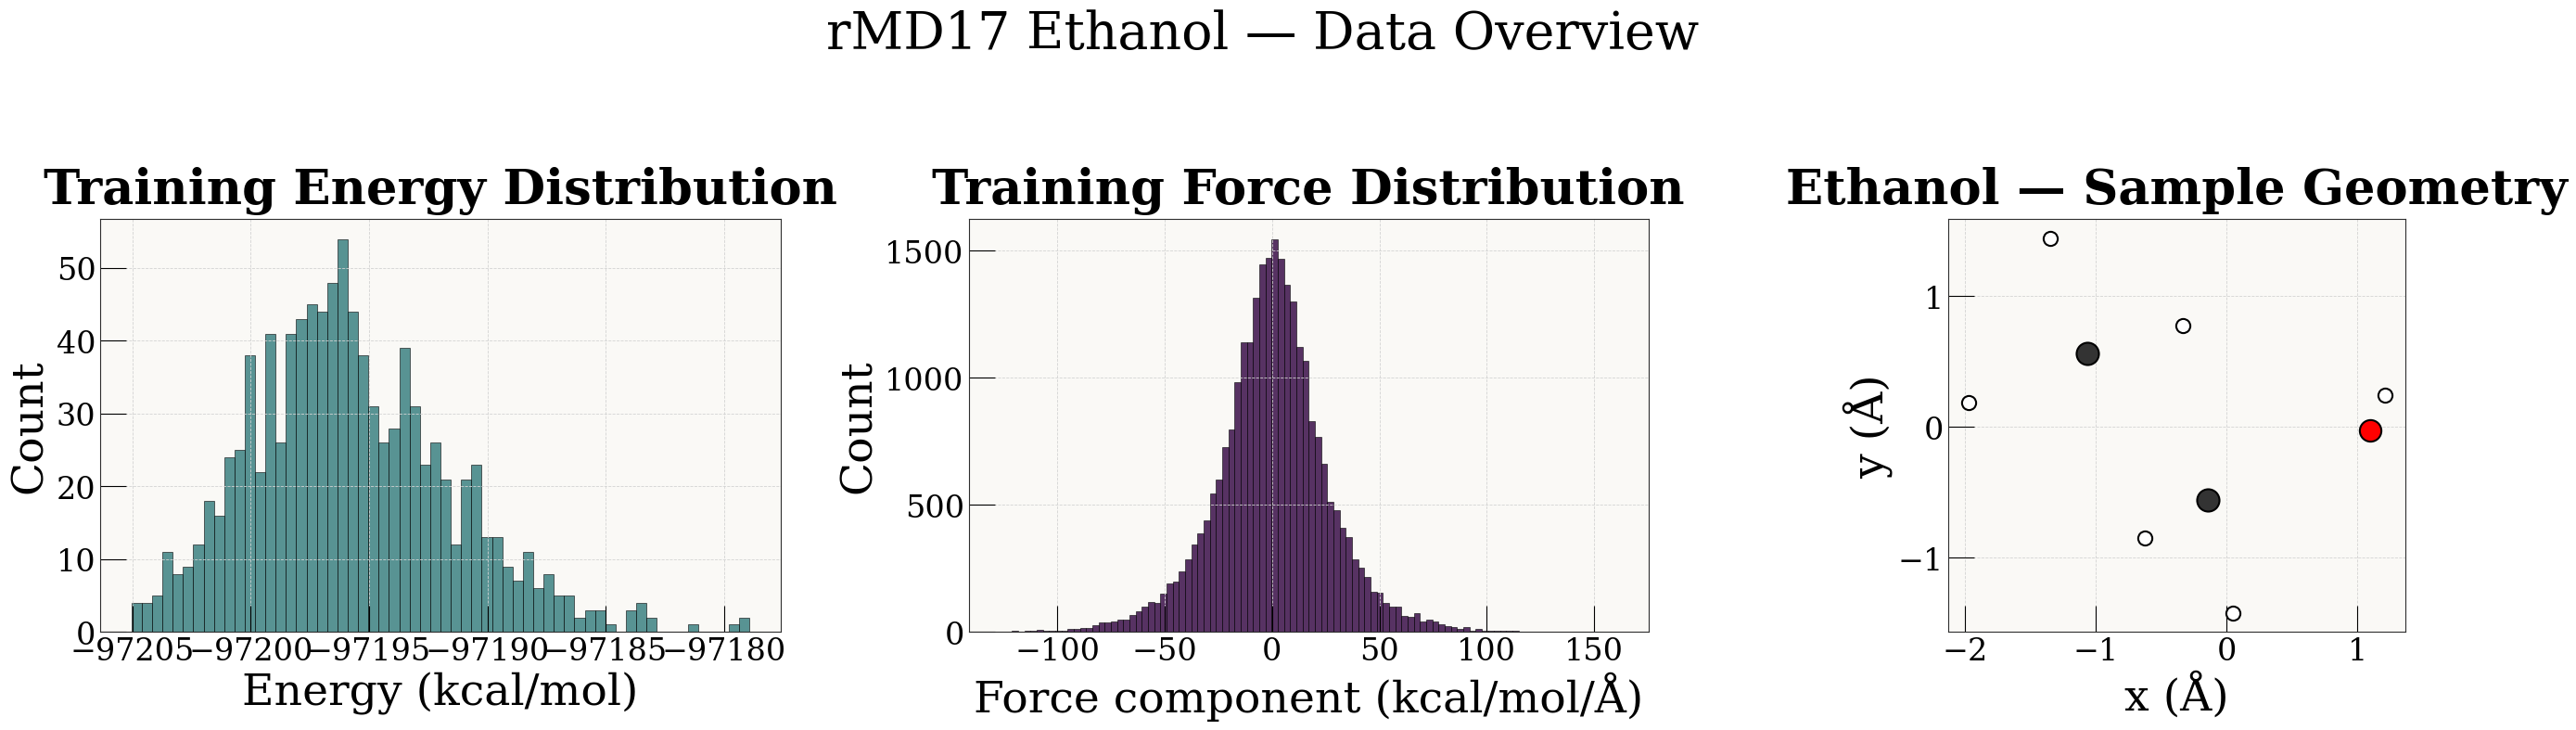

In [3]:
# ── Visualise data distributions ──────────────────────────────────
sample_batch = next(iter(splits.train_loader))
energies = [d.y.item() for d in splits.train_loader.dataset]
forces_flat = torch.cat([d.force.reshape(-1) for d in splits.train_loader.dataset])

fig, axes = plt.subplots(1, 3, figsize=(28, 8))

# Energy distribution
axes[0].hist(energies, bins=60, color=C["dhnn"], alpha=0.8, edgecolor="k", lw=0.5)
axes[0].set_xlabel("Energy (kcal/mol)")
axes[0].set_ylabel("Count")
axes[0].set_title("Training Energy Distribution")

# Force distribution
axes[1].hist(forces_flat.numpy(), bins=100, color=C["hnn"], alpha=0.8, edgecolor="k", lw=0.5)
axes[1].set_xlabel("Force component (kcal/mol/Å)")
axes[1].set_ylabel("Count")
axes[1].set_title("Training Force Distribution")

# One molecular snapshot (3D scatter of first config)
d0 = splits.train_loader.dataset[0]
pos0 = d0.pos.numpy()
z0 = d0.z.numpy()
atom_colors = {1: "white", 6: "#333333", 8: "red", 7: "blue"}
atom_sizes  = {1: 120, 6: 300, 8: 280, 7: 280}
for iz in np.unique(z0):
    mask = z0 == iz
    axes[2].scatter(
        pos0[mask, 0], pos0[mask, 1],
        s=atom_sizes.get(iz, 200), c=atom_colors.get(iz, "grey"),
        edgecolors="k", linewidths=1.5, zorder=3,
    )
axes[2].set_xlabel("x (Å)"); axes[2].set_ylabel("y (Å)")
axes[2].set_title("Ethanol — Sample Geometry")
axes[2].set_aspect("equal")

fig.suptitle("rMD17 Ethanol — Data Overview", fontsize=40, y=1.02)
fig.tight_layout()
fig.savefig("../figures/mol_ethanol_data_overview.pdf", bbox_inches="tight", dpi=150)
plt.show()

---
## 2. Copresheaf Hamiltonian — Force Field Training

Train a **Copresheaf Neural Network** as a differentiable potential $V_\theta(\mathbf{z}, \mathbf{r})$.

The copresheaf assigns feature stalks to atoms and interaction stalks to edges.  Extension maps $\mathcal{F}_{v \to e}$ project atomic features into a shared stalk space, conditioned on interatomic distance.

Loss: $\mathcal{L} = 0.01 \cdot \text{MSE}(E) + \text{MSE}(\mathbf{F})$ — force-dominated following NequIP/MACE convention.

In [12]:
model = CopresheafHamiltonian(
    d_node=256,
    d_stalk=32,
    n_layers=6,
    n_rbf=64,
    cutoff=5.0,
    mean=splits.mean_energy,
    std=splits.std_energy,
)

n_params = sum(p.numel() for p in model.parameters())
print(f"CopresheafHamiltonian parameters: {n_params:,}")
print(f"  d_node={256}, d_stalk={32}, n_layers={6}, n_rbf={64}")
print(f"Energy normalisation: μ={splits.mean_energy:.2f}, σ={splits.std_energy:.4f}")

CopresheafHamiltonian parameters: 1,098,689
  d_node=256, d_stalk=32, n_layers=6, n_rbf=64
Energy normalisation: μ=-97195.78, σ=4.2403


In [13]:
import os
ckpt = os.path.join(os.path.dirname(os.getcwd()), "checkpoints", "copresheaf_ethanol_v2.pt")

if os.path.exists(ckpt):
    model.load_state_dict(torch.load(ckpt, weights_only=True))
    model = model.to(DEVICE)
    print(f"✓ Loaded checkpoint: {ckpt}")
    history = None
else:
    history = train_schnet(
        model,
        splits.train_loader,
        splits.val_loader,
        epochs=500,
        lr=1e-3,
        energy_weight=0.01,
        device=DEVICE,
        patience=60,
        checkpoint_name="copresheaf_ethanol_v2.pt",
    )

SchNet:   0%|          | 0/500 [00:00<?, ?it/s]

  ✓ Best val force MAE: 0.5185 kcal/mol/Å
  ✓ Checkpoint: /Users/aleksandersekkelsten/D_HNN/checkpoints/copresheaf_ethanol_v2.pt


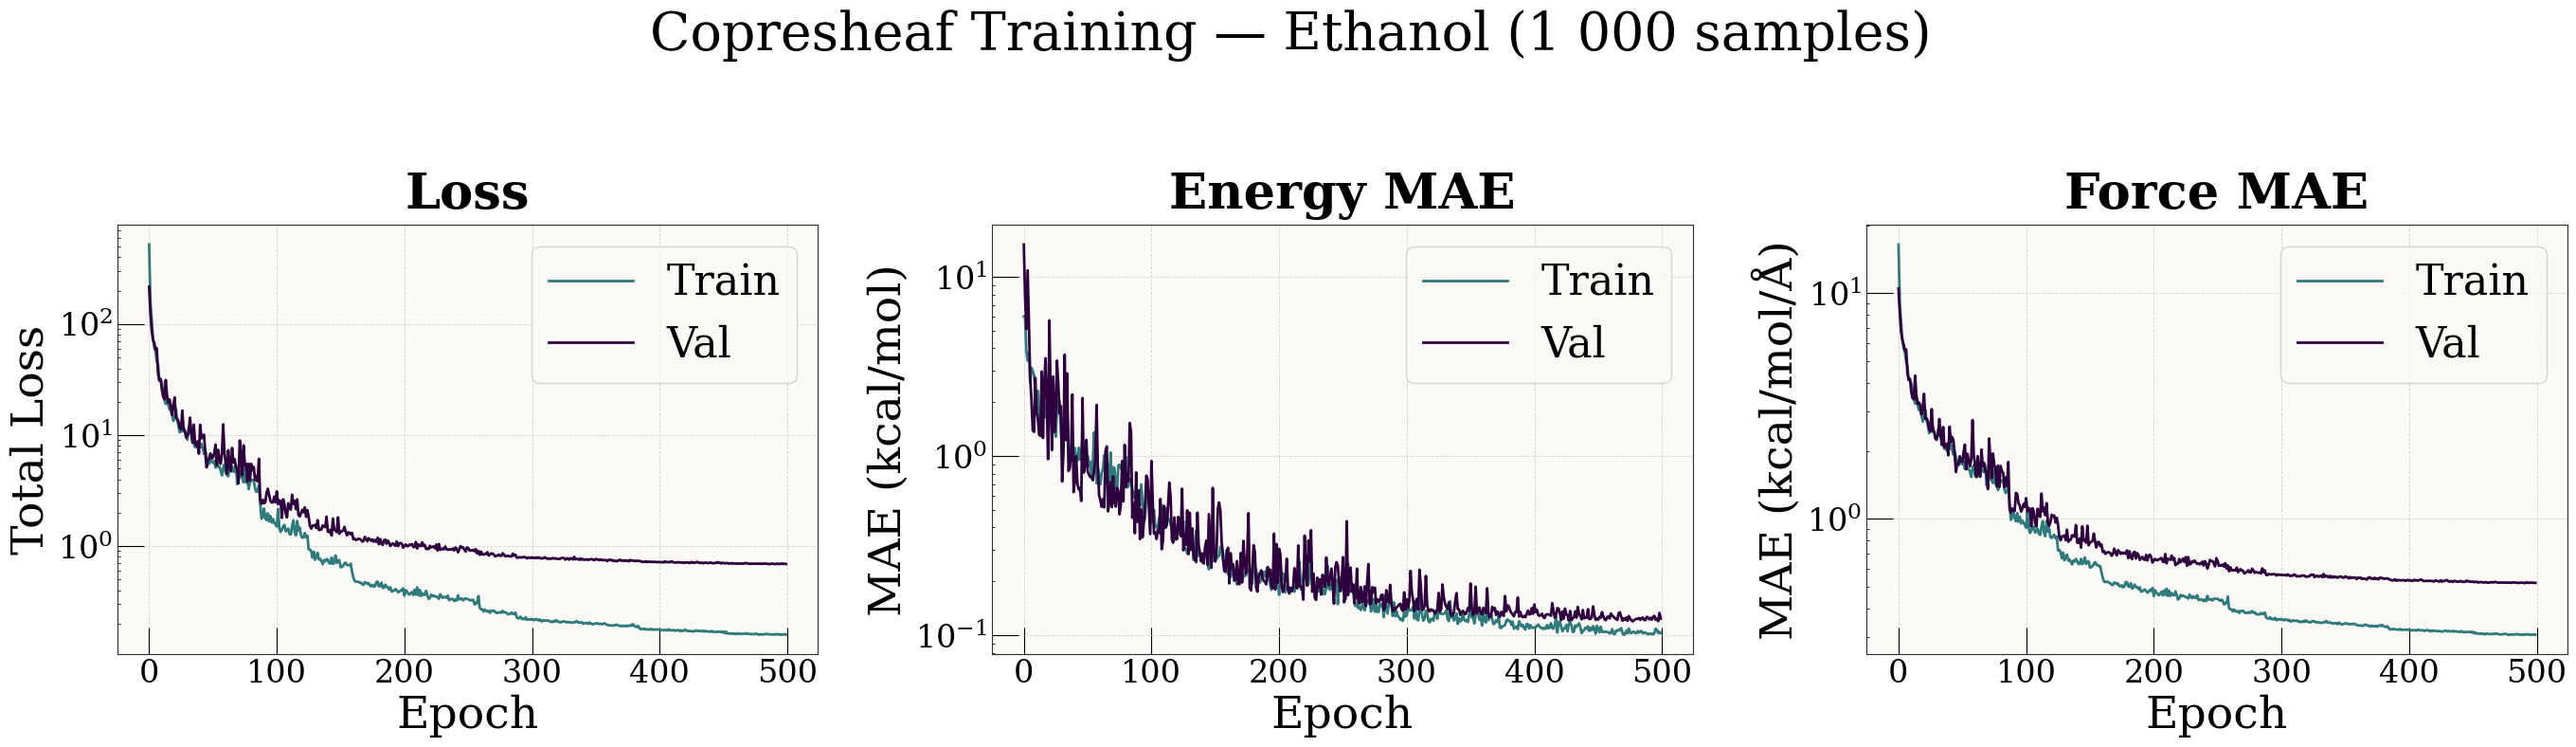

Final val  Energy MAE: 0.1242 kcal/mol
Final val  Force  MAE: 0.5192 kcal/mol/Å


In [14]:
if history is not None:
    # ── Training curves ───────────────────────────────────────────
    fig, axes = plt.subplots(1, 3, figsize=(28, 8))

    axes[0].semilogy(history["train_loss"], label="Train", color=C["dhnn"], lw=2)
    axes[0].semilogy(history["val_loss"],   label="Val",   color=C["hnn"],  lw=2)
    axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Total Loss")
    axes[0].set_title("Loss"); axes[0].legend()

    axes[1].semilogy(history["train_energy_mae"], label="Train", color=C["dhnn"], lw=2)
    axes[1].semilogy(history["val_energy_mae"],   label="Val",   color=C["hnn"],  lw=2)
    axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("MAE (kcal/mol)")
    axes[1].set_title("Energy MAE"); axes[1].legend()

    axes[2].semilogy(history["train_force_mae"], label="Train", color=C["dhnn"], lw=2)
    axes[2].semilogy(history["val_force_mae"],   label="Val",   color=C["hnn"],  lw=2)
    axes[2].set_xlabel("Epoch"); axes[2].set_ylabel("MAE (kcal/mol/Å)")
    axes[2].set_title("Force MAE"); axes[2].legend()

    fig.suptitle("Copresheaf Training — Ethanol (1 000 samples)", fontsize=40, y=1.02)
    fig.tight_layout()
    fig.savefig("../figures/mol_copresheaf_training.pdf", bbox_inches="tight", dpi=150)
    plt.show()

    print(f"Final val  Energy MAE: {history['val_energy_mae'][-1]:.4f} kcal/mol")
    print(f"Final val  Force  MAE: {history['val_force_mae'][-1]:.4f} kcal/mol/Å")
else:
    print("Loaded from checkpoint — training curves not available")

---
## 3. Normal Mode Analysis

Compute the Hessian $\partial^2 E / \partial r_i \partial r_j$ at the equilibrium geometry via autograd through the trained SchNet. Diagonalise the mass-weighted Hessian to obtain $3N - 6 = 21$ vibrational normal modes.

In [15]:
# Find equilibrium geometry (lowest energy in training set)
energies_all = torch.tensor([d.y.item() for d in splits.train_loader.dataset])
eq_idx = energies_all.argmin().item()
eq_data = splits.train_loader.dataset[eq_idx]
eq_pos = eq_data.pos
print(f"Equilibrium config index: {eq_idx}")
print(f"Equilibrium energy: {eq_data.y.item():.4f} kcal/mol")
print(f"Positions shape: {eq_pos.shape}")

Equilibrium config index: 424
Equilibrium energy: -97205.0469 kcal/mol
Positions shape: torch.Size([9, 3])


In [16]:
# Normal mode analysis via autograd Hessian
model_cpu = model.cpu()
nm_result = normal_mode_analysis(model_cpu, eq_data.z, eq_pos)

print(f"Number of internal modes: {len(nm_result.frequencies_cm1)}")
print(f"Expected (3N-6): {3 * splits.n_atoms - 6}")
print(f"\nVibrational frequencies (cm⁻¹):")
for i, freq in enumerate(nm_result.frequencies_cm1):
    print(f"  Mode {i+1:2d}: {freq:8.1f} cm⁻¹")

Number of internal modes: 24
Expected (3N-6): 21

Vibrational frequencies (cm⁻¹):
  Mode  1:   -209.6 cm⁻¹
  Mode  2:    -83.0 cm⁻¹
  Mode  3:    -54.4 cm⁻¹
  Mode  4:    415.1 cm⁻¹
  Mode  5:    440.7 cm⁻¹
  Mode  6:    510.0 cm⁻¹
  Mode  7:    779.3 cm⁻¹
  Mode  8:    882.7 cm⁻¹
  Mode  9:   1070.3 cm⁻¹
  Mode 10:   1113.9 cm⁻¹
  Mode 11:   1129.9 cm⁻¹
  Mode 12:   1227.1 cm⁻¹
  Mode 13:   1317.2 cm⁻¹
  Mode 14:   1373.4 cm⁻¹
  Mode 15:   1408.2 cm⁻¹
  Mode 16:   1432.6 cm⁻¹
  Mode 17:   1454.4 cm⁻¹
  Mode 18:   1490.8 cm⁻¹
  Mode 19:   2706.8 cm⁻¹
  Mode 20:   2900.9 cm⁻¹
  Mode 21:   2949.5 cm⁻¹
  Mode 22:   2997.8 cm⁻¹
  Mode 23:   3321.6 cm⁻¹
  Mode 24:   3464.2 cm⁻¹


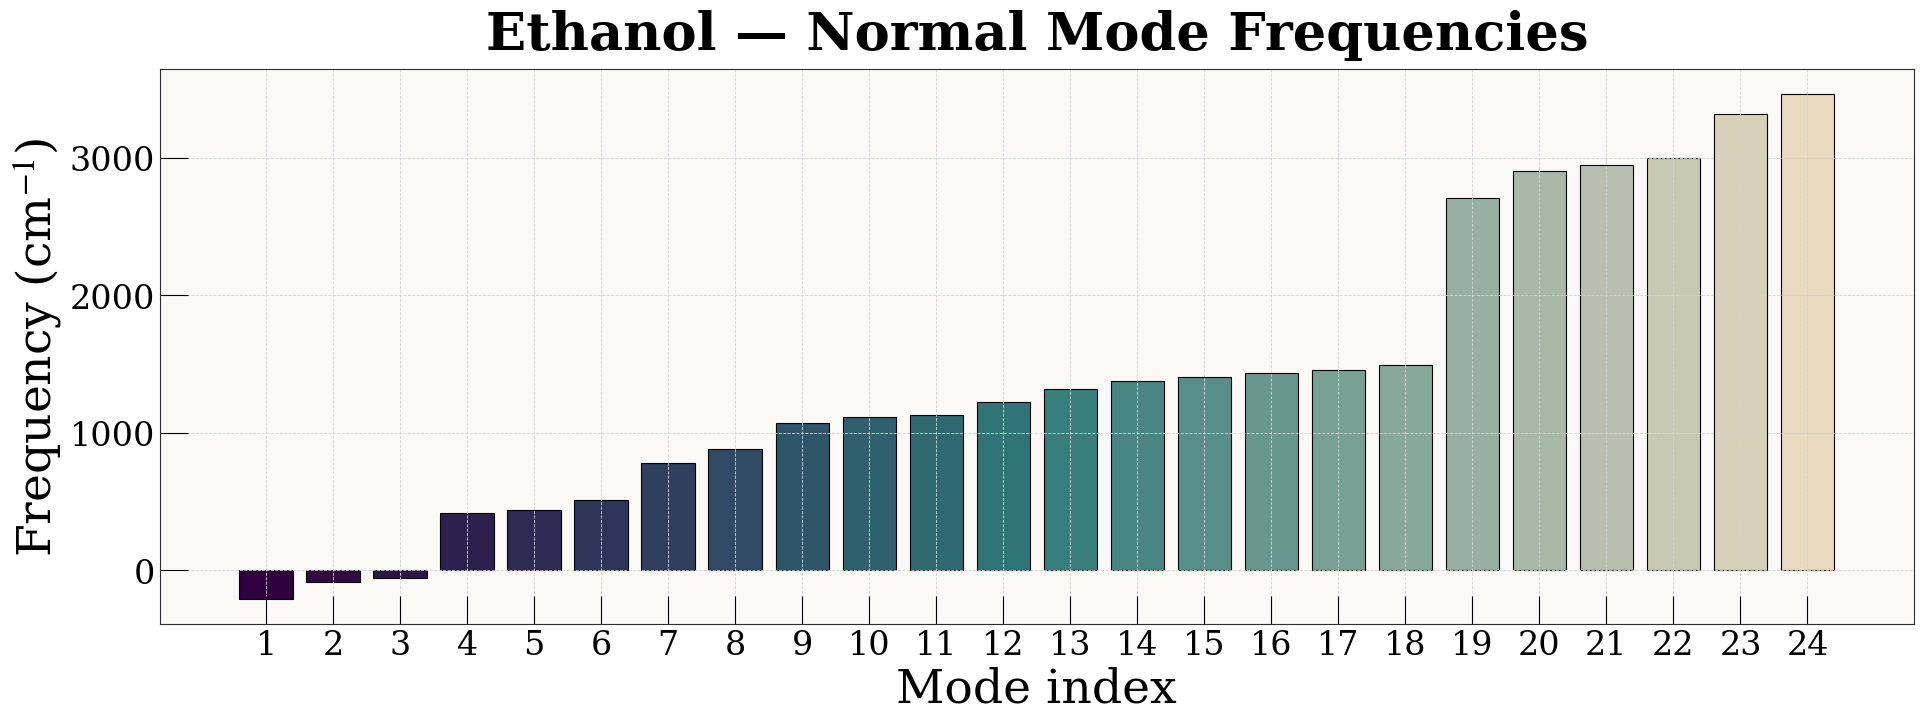

In [17]:
# ── Visualise normal mode spectrum ────────────────────────────────
fig, ax = plt.subplots(figsize=(20, 8))
freqs = nm_result.frequencies_cm1
colours = thesis_viridial(np.linspace(0, 1, len(freqs)))

ax.bar(range(1, len(freqs) + 1), freqs, color=colours, edgecolor="k", lw=0.8)
ax.set_xlabel("Mode index")
ax.set_ylabel("Frequency (cm$^{-1}$)")
ax.set_title("Ethanol — Normal Mode Frequencies")
ax.set_xticks(range(1, len(freqs) + 1))

fig.tight_layout()
fig.savefig("../figures/mol_normal_mode_spectrum.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [18]:
# ── Project all training configs into normal mode coordinates ─────
all_positions = np.stack([d.pos.numpy() for d in splits.train_loader.dataset])  # [1000, 9, 3]
Q_all = project_to_modes(all_positions, nm_result)  # [1000, 21]

print(f"Normal mode coordinates shape: {Q_all.shape}")
print(f"Mode amplitude std:  {Q_all.std(axis=0).round(4)}")

# Reconstruction error
recon = project_from_modes(Q_all, nm_result)
rmsd = np.sqrt(((recon - all_positions) ** 2).mean())
print(f"\nReconstruction RMSD: {rmsd:.6f} Å")

Normal mode coordinates shape: (1000, 24)
Mode amplitude std:  [1.706  2.3484 2.6869 2.2923 1.9103 0.7442 0.4924 2.2527 0.9101 1.6738
 1.6225 0.7463 0.6711 0.9504 0.5012 0.3317 0.5303 0.6771 0.7327 0.6238
 0.5856 0.5254 0.6347 0.5668]

Reconstruction RMSD: 0.000013 Å


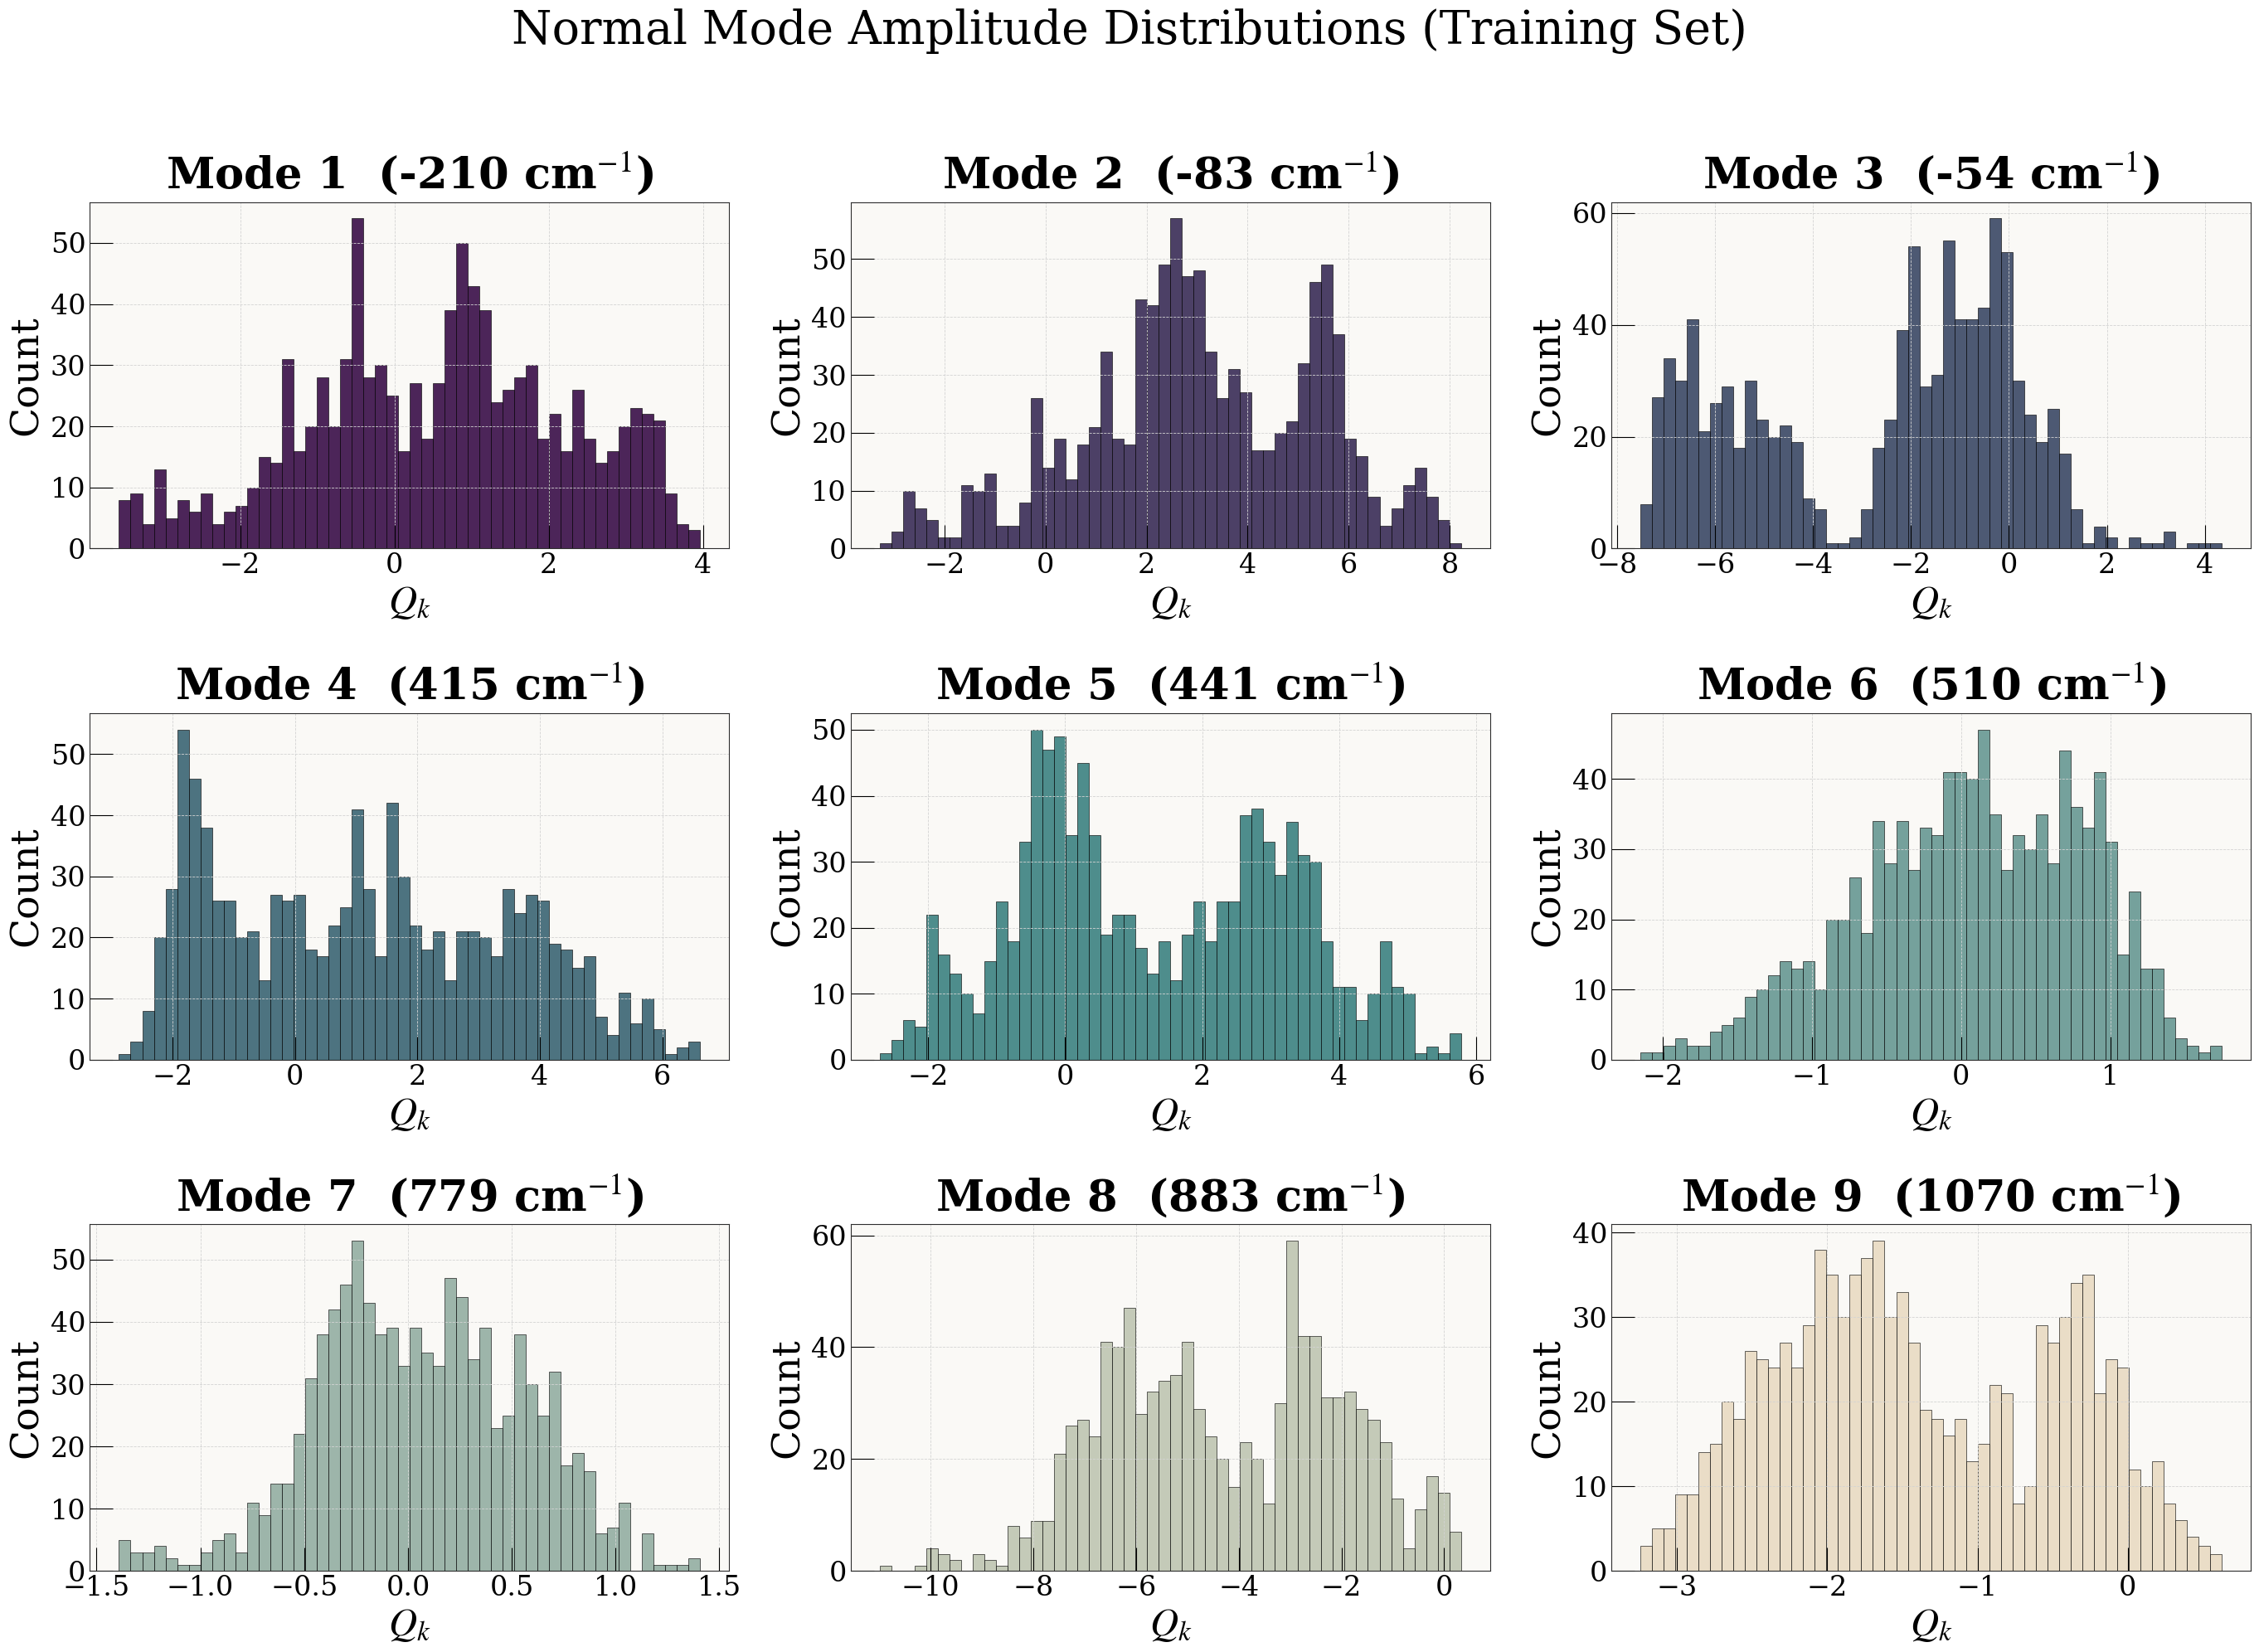

In [19]:
# ── Normal mode amplitude distributions ──────────────────────────
n_show = min(9, Q_all.shape[1])
fig, axes = plt.subplots(3, 3, figsize=(28, 20))

for i, ax in enumerate(axes.flat[:n_show]):
    ax.hist(Q_all[:, i], bins=50,
            color=thesis_viridial(i / max(n_show - 1, 1)),
            alpha=0.85, edgecolor="k", lw=0.5)
    ax.set_title(f"Mode {i+1}  ({freqs[i]:.0f} cm$^{{-1}}$)")
    ax.set_xlabel("$Q_k$")
    ax.set_ylabel("Count")

fig.suptitle("Normal Mode Amplitude Distributions (Training Set)",
             fontsize=40, y=1.01)
fig.tight_layout()
fig.savefig("../figures/mol_mode_distributions.pdf", bbox_inches="tight", dpi=150)
plt.show()

---
## 4. Normal Mode D-HNN — Latent Hamiltonian Dynamics

The MD17 dataset contains consecutive MD frames sampled at $\Delta t = 0.5$ fs. We can:

1. **Project** all frames into normal mode coordinates $Q_k(t)$
2. **Estimate momenta** via finite differences: $P_k(t) \approx (Q_k(t + \Delta t) - Q_k(t - \Delta t)) / (2 \Delta t)$
3. **Train a D-HNN** on $(Q, P) \to (\dot{Q}, \dot{P})$ where:

$$\dot{Q}_k = \frac{\partial H_\theta}{\partial P_k}, \qquad \dot{P}_k = -\frac{\partial H_\theta}{\partial Q_k} + \rho \frac{\partial D_\theta}{\partial P_k}$$

The D-HNN guarantees the learned dynamics decomposes into a conservative Hamiltonian part and a dissipative correction, providing physical interpretability.

In [20]:
# ── Prepare (Q, P) dataset from MD trajectory ────────────────────
# MD17 frames are consecutive MD snapshots at dt = 0.5 fs
# We use ALL data (not just 1000 train) — the MD trajectory is
# independent of the force-field training split

# Get the full dataset in trajectory order
from torch_geometric.datasets import MD17
from pathlib import Path
data_root = Path(os.path.dirname(os.getcwd())) / "data"
dataset_full = MD17(root=str(data_root), name="ethanol")

# Project ALL positions into normal mode coordinates
print(f"Total MD frames: {len(dataset_full)}")
all_pos_full = np.stack([dataset_full[i].pos.float().numpy() for i in range(len(dataset_full))])
Q_full = project_to_modes(all_pos_full, nm_result)
print(f"Normal mode trajectory shape: {Q_full.shape}")

# ── Estimate momenta via central differences ─────────────────────
dt_fs = 0.5   # fs (MD17 timestep)
dt_au = dt_fs * 41.341  # convert to atomic units (1 fs = 41.341 a.u.)

# Central difference: P(t) ≈ (Q(t+dt) - Q(t-dt)) / (2*dt)
P_full = np.zeros_like(Q_full)
P_full[1:-1] = (Q_full[2:] - Q_full[:-2]) / (2.0 * dt_fs)
P_full[0] = (Q_full[1] - Q_full[0]) / dt_fs
P_full[-1] = (Q_full[-1] - Q_full[-2]) / dt_fs

# ── Compute time derivatives (targets) ───────────────────────────
# dQ/dt ≈ (Q(t+dt) - Q(t)) / dt
# dP/dt ≈ (P(t+dt) - P(t)) / dt  
dQ = np.zeros_like(Q_full)
dP = np.zeros_like(P_full)
dQ[:-1] = (Q_full[1:] - Q_full[:-1]) / dt_fs
dQ[-1] = dQ[-2]
dP[:-1] = (P_full[1:] - P_full[:-1]) / dt_fs
dP[-1] = dP[-2]

# ── State: x = [Q, P],  target: y = [dQ/dt, dP/dt] ─────────────
n_modes = Q_full.shape[1]
x_all = np.concatenate([Q_full, P_full], axis=1)  # [N, 2*K]
y_all = np.concatenate([dQ, dP], axis=1)            # [N, 2*K]

# Trim edges where finite differences are unreliable
x_all = x_all[2:-2]
y_all = y_all[2:-2]

print(f"\nState vector dim:  {x_all.shape[1]}  (Q + P for {n_modes} modes)")
print(f"Training samples:  {len(x_all):,}")
print(f"Q range:  [{Q_full.min():.2f}, {Q_full.max():.2f}]")
print(f"P range:  [{P_full.min():.2f}, {P_full.max():.2f}]")
print(f"dQ range: [{dQ.min():.2f}, {dQ.max():.2f}]")
print(f"dP range: [{dP.min():.2f}, {dP.max():.2f}]")

Total MD frames: 555092
Normal mode trajectory shape: (555092, 24)

State vector dim:  48  (Q + P for 24 modes)
Training samples:  555,088
Q range:  [-11.03, 8.34]
P range:  [-0.11, 0.12]
dQ range: [-0.11, 0.12]
dP range: [-0.07, 0.08]


In [30]:
# ── Symplectic normalisation + time rescaling ─────────────────────
# 1. Symplectic normalisation:  a_k·b_k = 1  for each mode pair
#    → preserves the canonical 2-form dQ∧dP.
# 2. Global time rescaling:  τ = y_rms · t
#    → brings targets to O(1) for better optimisation,
#      equivalent to learning H/y_rms (symplecticity untouched).

Q_std = Q_full[1:-1].std(axis=0)
P_std = P_full[1:-1].std(axis=0)
Q_mean_nm = Q_full[1:-1].mean(axis=0)
P_mean_nm = P_full[1:-1].mean(axis=0)

a_symp = np.sqrt(Q_std / (P_std + 1e-12)) + 1e-12   # Q scaling
b_symp = 1.0 / a_symp                                 # P scaling

Q_norm = (Q_full[1:-1] - Q_mean_nm) / a_symp
P_norm = (P_full[1:-1] - P_mean_nm) / b_symp

dQ_norm = dQ / a_symp
dP_norm = dP / b_symp

x_symp = np.concatenate([Q_norm,  P_norm],  axis=1)   # (N, 48)
y_symp = np.concatenate([dQ_norm, dP_norm], axis=1)    # dx̃/dt

# Global rescaling: y' = y / y_scale   (rollout: dt_eff = dt_au · y_scale)
y_scale = np.sqrt(np.mean(y_symp ** 2))
y_scaled = y_symp / y_scale

# Train / test split
np.random.seed(42)
idx = np.arange(len(x_symp))
np.random.shuffle(idx)
n_train = int(0.9 * len(idx))

x_train = x_symp[idx[:n_train]]
y_train = y_scaled[idx[:n_train]]
x_test  = x_symp[idx[n_train:]]
y_test  = y_scaled[idx[n_train:]]

print(f"Train: {len(x_train):,}  |  Test: {len(x_test):,}")
print(f"x  std range : [{x_symp.std(0).min():.4f}, {x_symp.std(0).max():.4f}]")
print(f"y  raw std   : [{y_symp.std(0).min():.6f}, {y_symp.std(0).max():.6f}]")
print(f"y_scale      : {y_scale:.6f}")
print(f"y' std range : [{y_scaled.std(0).min():.4f}, {y_scaled.std(0).max():.4f}]")
print(f"dt_eff for rollout: {dt_au * y_scale:.4f} a.u. = {dt_fs * y_scale:.6f} fs")

Train: 499,581  |  Test: 55,509
x  std range : [0.0875, 0.2126]
y  raw std   : [0.001219, 0.067519]
y_scale      : 0.035148
y' std range : [0.0347, 1.9210]
dt_eff for rollout: 0.7265 a.u. = 0.017574 fs


In [31]:
# ── Train D-HNN in symplectically normalised space ────────────────
from dhnn.models import DHNN

nm_dhnn = DHNN(input_dim=2 * n_modes, hidden_dim=512, n_hidden=3)
n_dhnn_params = sum(p.numel() for p in nm_dhnn.parameters())
print(f"Normal-Mode D-HNN: {n_dhnn_params:,} parameters")
print(f"  H_net: 48 → 512 → 512 → 512 → 1  (Tanh)")

X_tr = torch.tensor(x_train, dtype=torch.float32)
Y_tr = torch.tensor(y_train, dtype=torch.float32)
X_te = torch.tensor(x_test,  dtype=torch.float32)
Y_te = torch.tensor(y_test,  dtype=torch.float32)

y_var = Y_te.var().item()
print(f"  Target variance: {y_var:.4f}")

optimizer = torch.optim.AdamW(nm_dhnn.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1000, T_mult=2
)

train_losses, test_losses = [], []
best_test = float('inf')

# ρ > 0 to capture anharmonic, non-Hamiltonian coupling between modes
rho = 0.1

N_EPOCHS = 5000
BATCH    = 4096

for epoch in range(1, N_EPOCHS + 1):
    nm_dhnn.train()
    bi = torch.randperm(len(X_tr))[:BATCH]

    pred = nm_dhnn.time_derivative(X_tr[bi], rho=rho)
    loss = ((pred - Y_tr[bi]) ** 2).mean()

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(nm_dhnn.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    if epoch % 50 == 0 or epoch == 1:
        nm_dhnn.eval()
        with torch.no_grad():
            ev = torch.randperm(len(X_te))[:8000]
            te_pred = nm_dhnn.time_derivative(X_te[ev], rho=rho)
            te_loss = ((te_pred - Y_te[ev]) ** 2).mean().item()
            tr_pred = nm_dhnn.time_derivative(X_tr[ev], rho=rho)
            tr_loss = ((tr_pred - Y_tr[ev]) ** 2).mean().item()
        train_losses.append(tr_loss)
        test_losses.append(te_loss)
        if te_loss < best_test:
            best_test = te_loss
            torch.save(nm_dhnn.state_dict(), "../checkpoints/nm_dhnn_ethanol.pt")
        if epoch % 1000 == 0 or epoch == 1:
            r2 = 1.0 - te_loss / y_var
            print(f"  Epoch {epoch:5d} │ Train {tr_loss:.6f} │ Test {te_loss:.6f} │ R² {r2:.4f}")

nm_dhnn.load_state_dict(torch.load("../checkpoints/nm_dhnn_ethanol.pt", weights_only=True))
r2_best = 1.0 - best_test / y_var
print(f"\n✓ Best test MSE: {best_test:.6f}  |  R²: {r2_best:.4f}  |  ρ = {rho}")

Normal-Mode D-HNN: 1,101,826 parameters
  H_net: 48 → 512 → 512 → 512 → 1  (Tanh)
  Target variance: 1.0021
  Epoch     1 │ Train 1.013156 │ Test 1.001760 │ R² 0.0003
  Epoch  1000 │ Train 0.869236 │ Test 0.864505 │ R² 0.1373
  Epoch  2000 │ Train 0.733765 │ Test 0.727462 │ R² 0.2740
  Epoch  3000 │ Train 0.642786 │ Test 0.637163 │ R² 0.3641
  Epoch  4000 │ Train 0.463516 │ Test 0.459545 │ R² 0.5414
  Epoch  5000 │ Train 0.338691 │ Test 0.343059 │ R² 0.6576

✓ Best test MSE: 0.343059  |  R²: 0.6576  |  ρ = 0.1


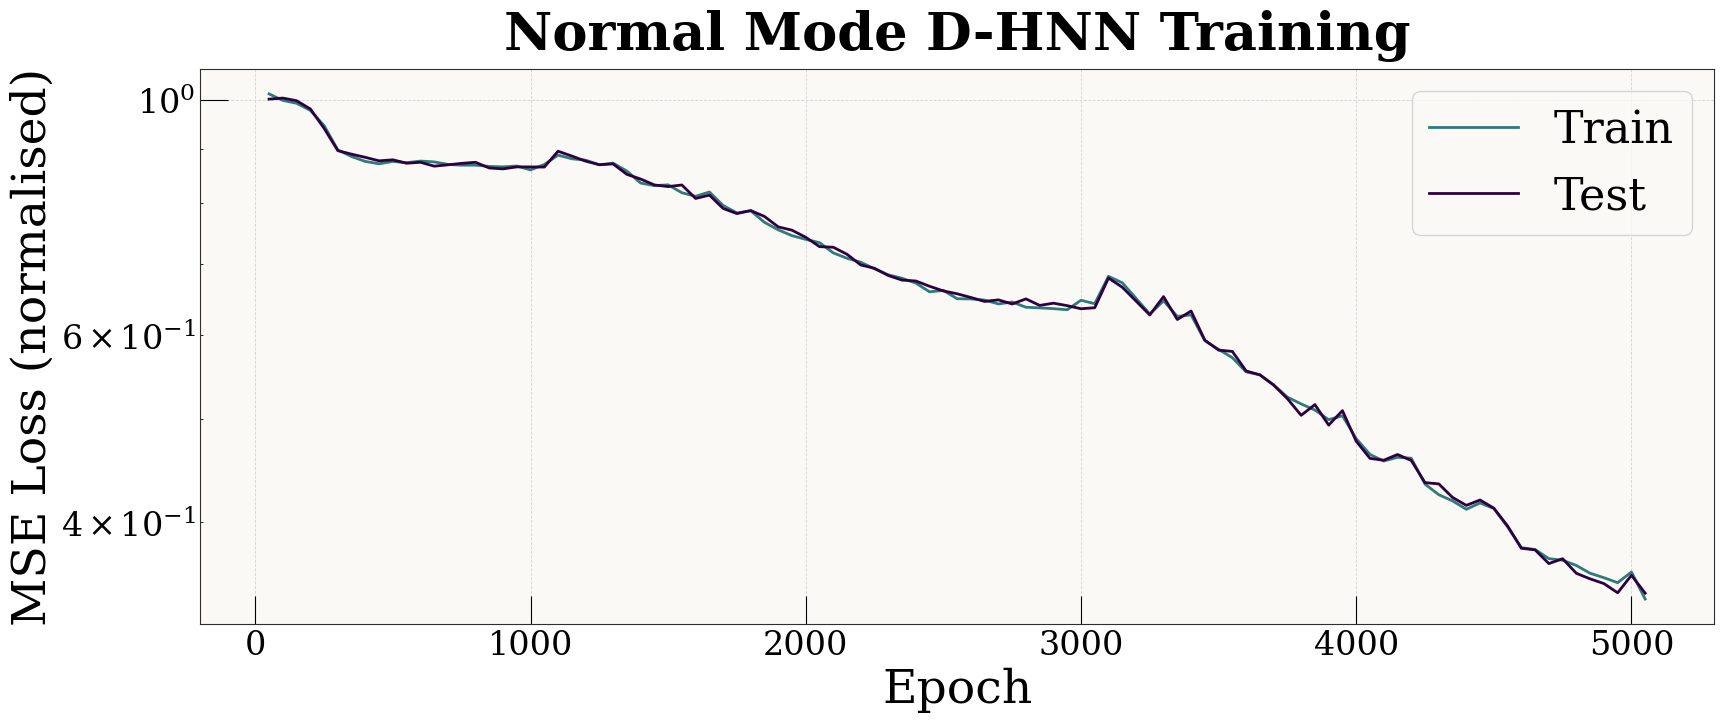

Final test MSE: 0.343059


In [32]:
# ── D-HNN Training Curves ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(18, 8))
epochs_plot = np.arange(1, len(train_losses)+1) * 50
ax.semilogy(epochs_plot, train_losses, label="Train", color=C["dhnn"], lw=2)
ax.semilogy(epochs_plot, test_losses,  label="Test",  color=C["hnn"],  lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss (normalised)")
ax.set_title("Normal Mode D-HNN Training")
ax.legend()
fig.tight_layout()
fig.savefig("../figures/mol_nm_dhnn_training.pdf", bbox_inches="tight", dpi=150)
plt.show()
print(f"Final test MSE: {test_losses[-1]:.6f}")

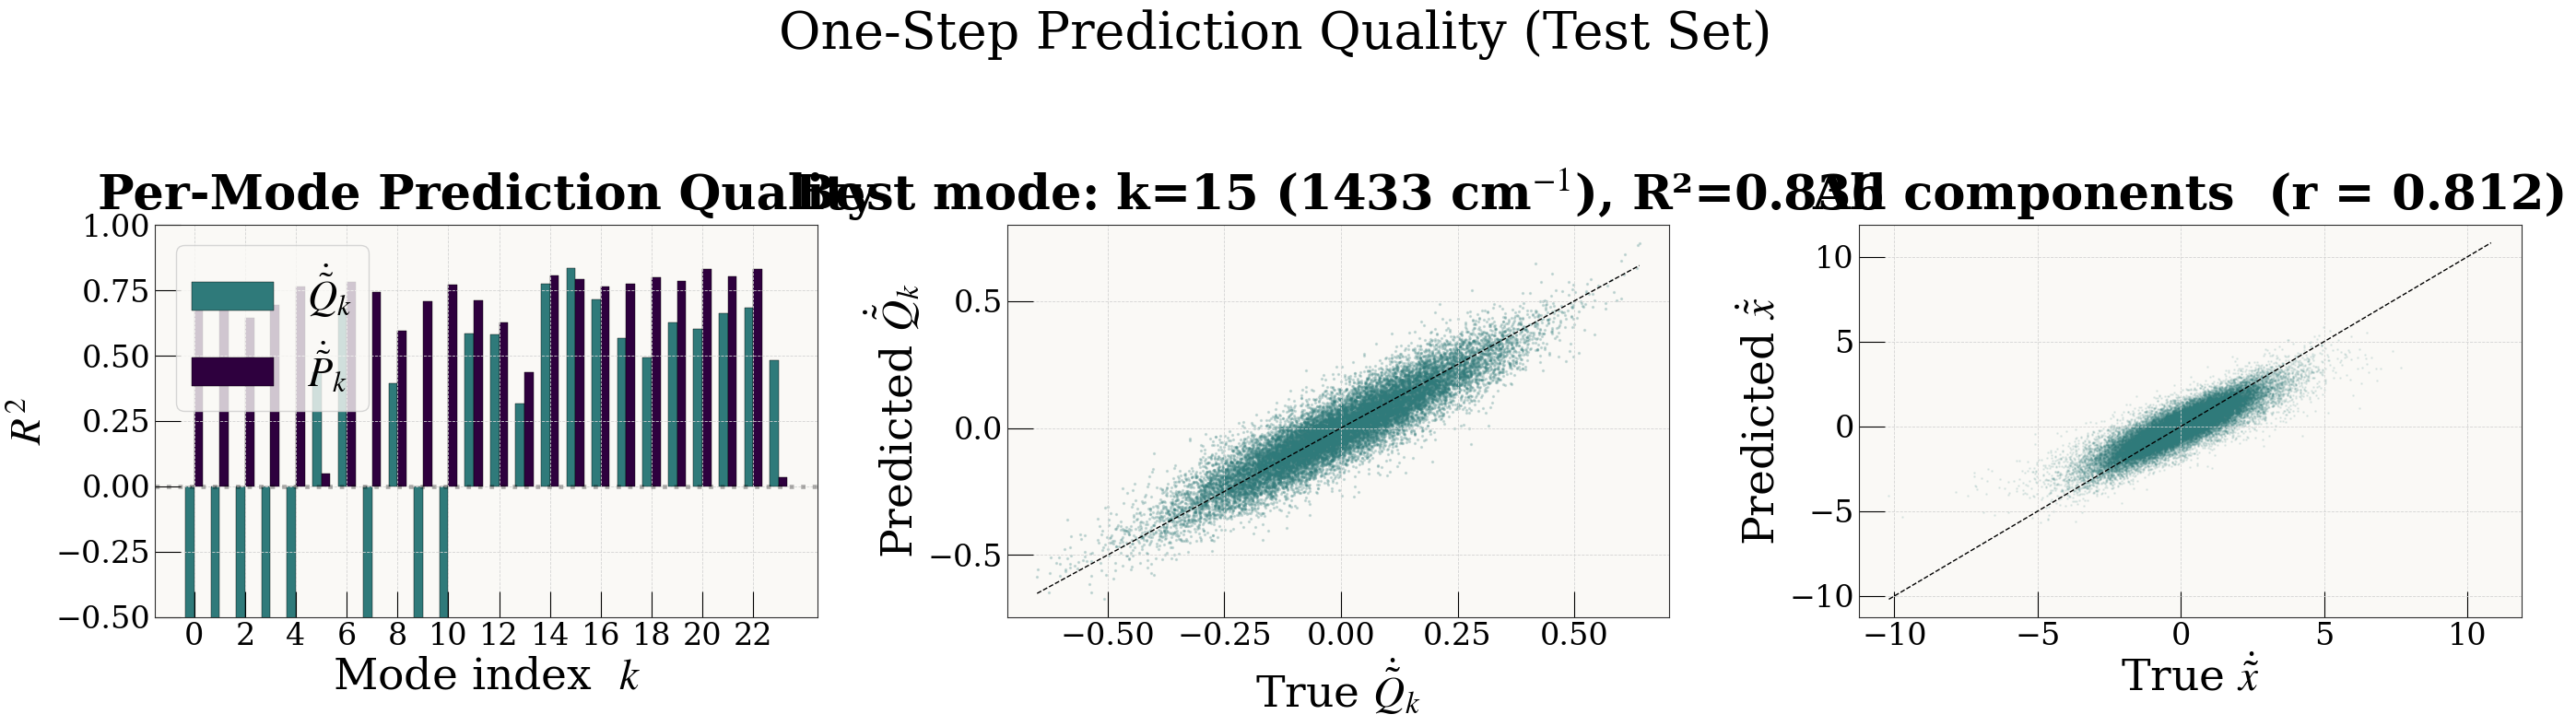

Overall R² (all components):  0.6590
Mean R²(dQ̃) phys modes:      0.1918  (range [-1.483, 0.836])
Mean R²(dP̃) phys modes:      0.6721  (range [0.037, 0.833])


In [38]:
# ── One-step prediction quality ────────────────────────────────────
nm_dhnn.eval()
n_eval = 20000
ev_idx = torch.randperm(len(X_te))[:n_eval]
with torch.no_grad():
    y_pred = nm_dhnn.time_derivative(X_te[ev_idx], rho=rho).numpy()
    y_true = Y_te[ev_idx].numpy()

# Per-component R²
r2_per = 1 - np.mean((y_pred - y_true)**2, axis=0) / (np.var(y_true, axis=0) + 1e-12)

# Split into dQ and dP
r2_dQ = r2_per[:n_modes]
r2_dP = r2_per[n_modes:]

fig, axes = plt.subplots(1, 3, figsize=(28, 8))

# Bar chart: per-mode R²
ax = axes[0]
width = 0.35
x_bar = np.arange(n_modes)
ax.bar(x_bar - width/2, r2_dQ, width, color=C["dhnn"], label="$\\dot{\\tilde{Q}}_k$", edgecolor="k", lw=0.3)
ax.bar(x_bar + width/2, r2_dP, width, color=C["hnn"],  label="$\\dot{\\tilde{P}}_k$", edgecolor="k", lw=0.3)
ax.set_xlabel("Mode index  $k$")
ax.set_ylabel("$R^2$")
ax.set_title("Per-Mode Prediction Quality")
ax.legend()
ax.set_xticks(x_bar[::2])
ax.set_ylim([-0.5, 1.0])
ax.axhline(0, ls=":", color="k", alpha=0.3)

# Scatter: best-predicted mode
best_idx = np.argmax(r2_per[:n_modes])
ax = axes[1]
ax.scatter(y_true[:, best_idx], y_pred[:, best_idx], s=2, alpha=0.2, c=C["dhnn"], rasterized=True)
lims = [y_true[:, best_idx].min(), y_true[:, best_idx].max()]
ax.plot(lims, lims, "k--", lw=1)
ax.set_xlabel("True $\\dot{\\tilde{Q}}_k$")
ax.set_ylabel("Predicted $\\dot{\\tilde{Q}}_k$")
ax.set_title(f"Best mode: k={best_idx} ({freqs[best_idx]:.0f} cm$^{{-1}}$), R²={r2_dQ[best_idx]:.3f}")

# Overall scatter (all components)
ax = axes[2]
ax.scatter(y_true.ravel()[::10], y_pred.ravel()[::10], s=1, alpha=0.1, c=C["dhnn"], rasterized=True)
lims = [y_true.ravel().min(), y_true.ravel().max()]
ax.plot(lims, lims, "k--", lw=1)
ax.set_xlabel("True $\\dot{\\tilde{x}}$")
ax.set_ylabel("Predicted $\\dot{\\tilde{x}}$")
from scipy.stats import pearsonr
r_all = pearsonr(y_true.ravel(), y_pred.ravel())[0]
ax.set_title(f"All components  (r = {r_all:.3f})")

fig.suptitle("One-Step Prediction Quality (Test Set)", fontsize=40, y=1.02)
fig.tight_layout()
fig.savefig("../figures/mol_nm_dhnn_onestep.pdf", bbox_inches="tight", dpi=150)
plt.show()

# Summary stats
r2_Q_phys = r2_dQ[3:]  # skip imaginary modes
r2_P_phys = r2_dP[3:]
print(f"Overall R² (all components):  {1 - np.mean((y_pred - y_true)**2) / np.var(y_true):.4f}")
print(f"Mean R²(dQ̃) phys modes:      {r2_Q_phys.mean():.4f}  (range [{r2_Q_phys.min():.3f}, {r2_Q_phys.max():.3f}])")
print(f"Mean R²(dP̃) phys modes:      {r2_P_phys.mean():.4f}  (range [{r2_P_phys.min():.3f}, {r2_P_phys.max():.3f}])")

---
### 4.1 Rollout — D-HNN Trajectory vs Ground Truth

Starting from a true initial condition $(Q_0, P_0)$, integrate the D-HNN forward using RK4 for 10 000+ steps and compare against the reference MD trajectory.

In [33]:
# ── Rollout: D-HNN trajectory vs ground truth ────────────────────
from dhnn.integrators import rollout

nm_dhnn.eval()

start_frame = 100_000
n_rollout   = 10_000      # 10k steps

# Ground truth in normal-mode space
Q_gt = Q_full[start_frame : start_frame + n_rollout + 1]
P_gt = P_full[start_frame : start_frame + n_rollout + 1]

# Symplectically normalise the ground truth
Q_gt_n = (Q_gt - Q_mean_nm) / a_symp
P_gt_n = (P_gt - P_mean_nm) / b_symp
x_gt_n = np.concatenate([Q_gt_n, P_gt_n], axis=1)

# Dynamics in rescaled time: model predicts dx̃/dτ = (1/y_scale)·dx̃/dt
def dynamics_fn(x_tensor):
    return nm_dhnn.time_derivative(x_tensor.unsqueeze(0), rho=rho).squeeze(0)

# dt in rescaled time units:  dτ = y_scale · dt_phys
dt_eff = dt_au * y_scale

x0 = x_gt_n[0].astype(np.float32)
traj_norm = rollout(dynamics_fn, x0, dt=dt_eff, n_steps=n_rollout)

# De-normalise to physical coordinates
Q_pred = traj_norm[:, :n_modes] * a_symp + Q_mean_nm
P_pred = traj_norm[:, n_modes:] * b_symp + P_mean_nm

phys_dt_per_step = dt_fs  # each step = one MD frame = 0.5 fs
total_time_fs = n_rollout * phys_dt_per_step
print(f"Rollout: {n_rollout} steps  ({total_time_fs:.0f} fs = {total_time_fs/1000:.1f} ps)")
print(f"dt_eff = {dt_eff:.4f} (rescaled a.u.)  ↔  {phys_dt_per_step} fs/step")
print(f"Q_pred shape: {Q_pred.shape}  |  Q_gt shape: {Q_gt.shape}")

Rollout: 10000 steps  (5000 fs = 5.0 ps)
dt_eff = 0.7265 (rescaled a.u.)  ↔  0.5 fs/step
Q_pred shape: (10001, 24)  |  Q_gt shape: (10001, 24)


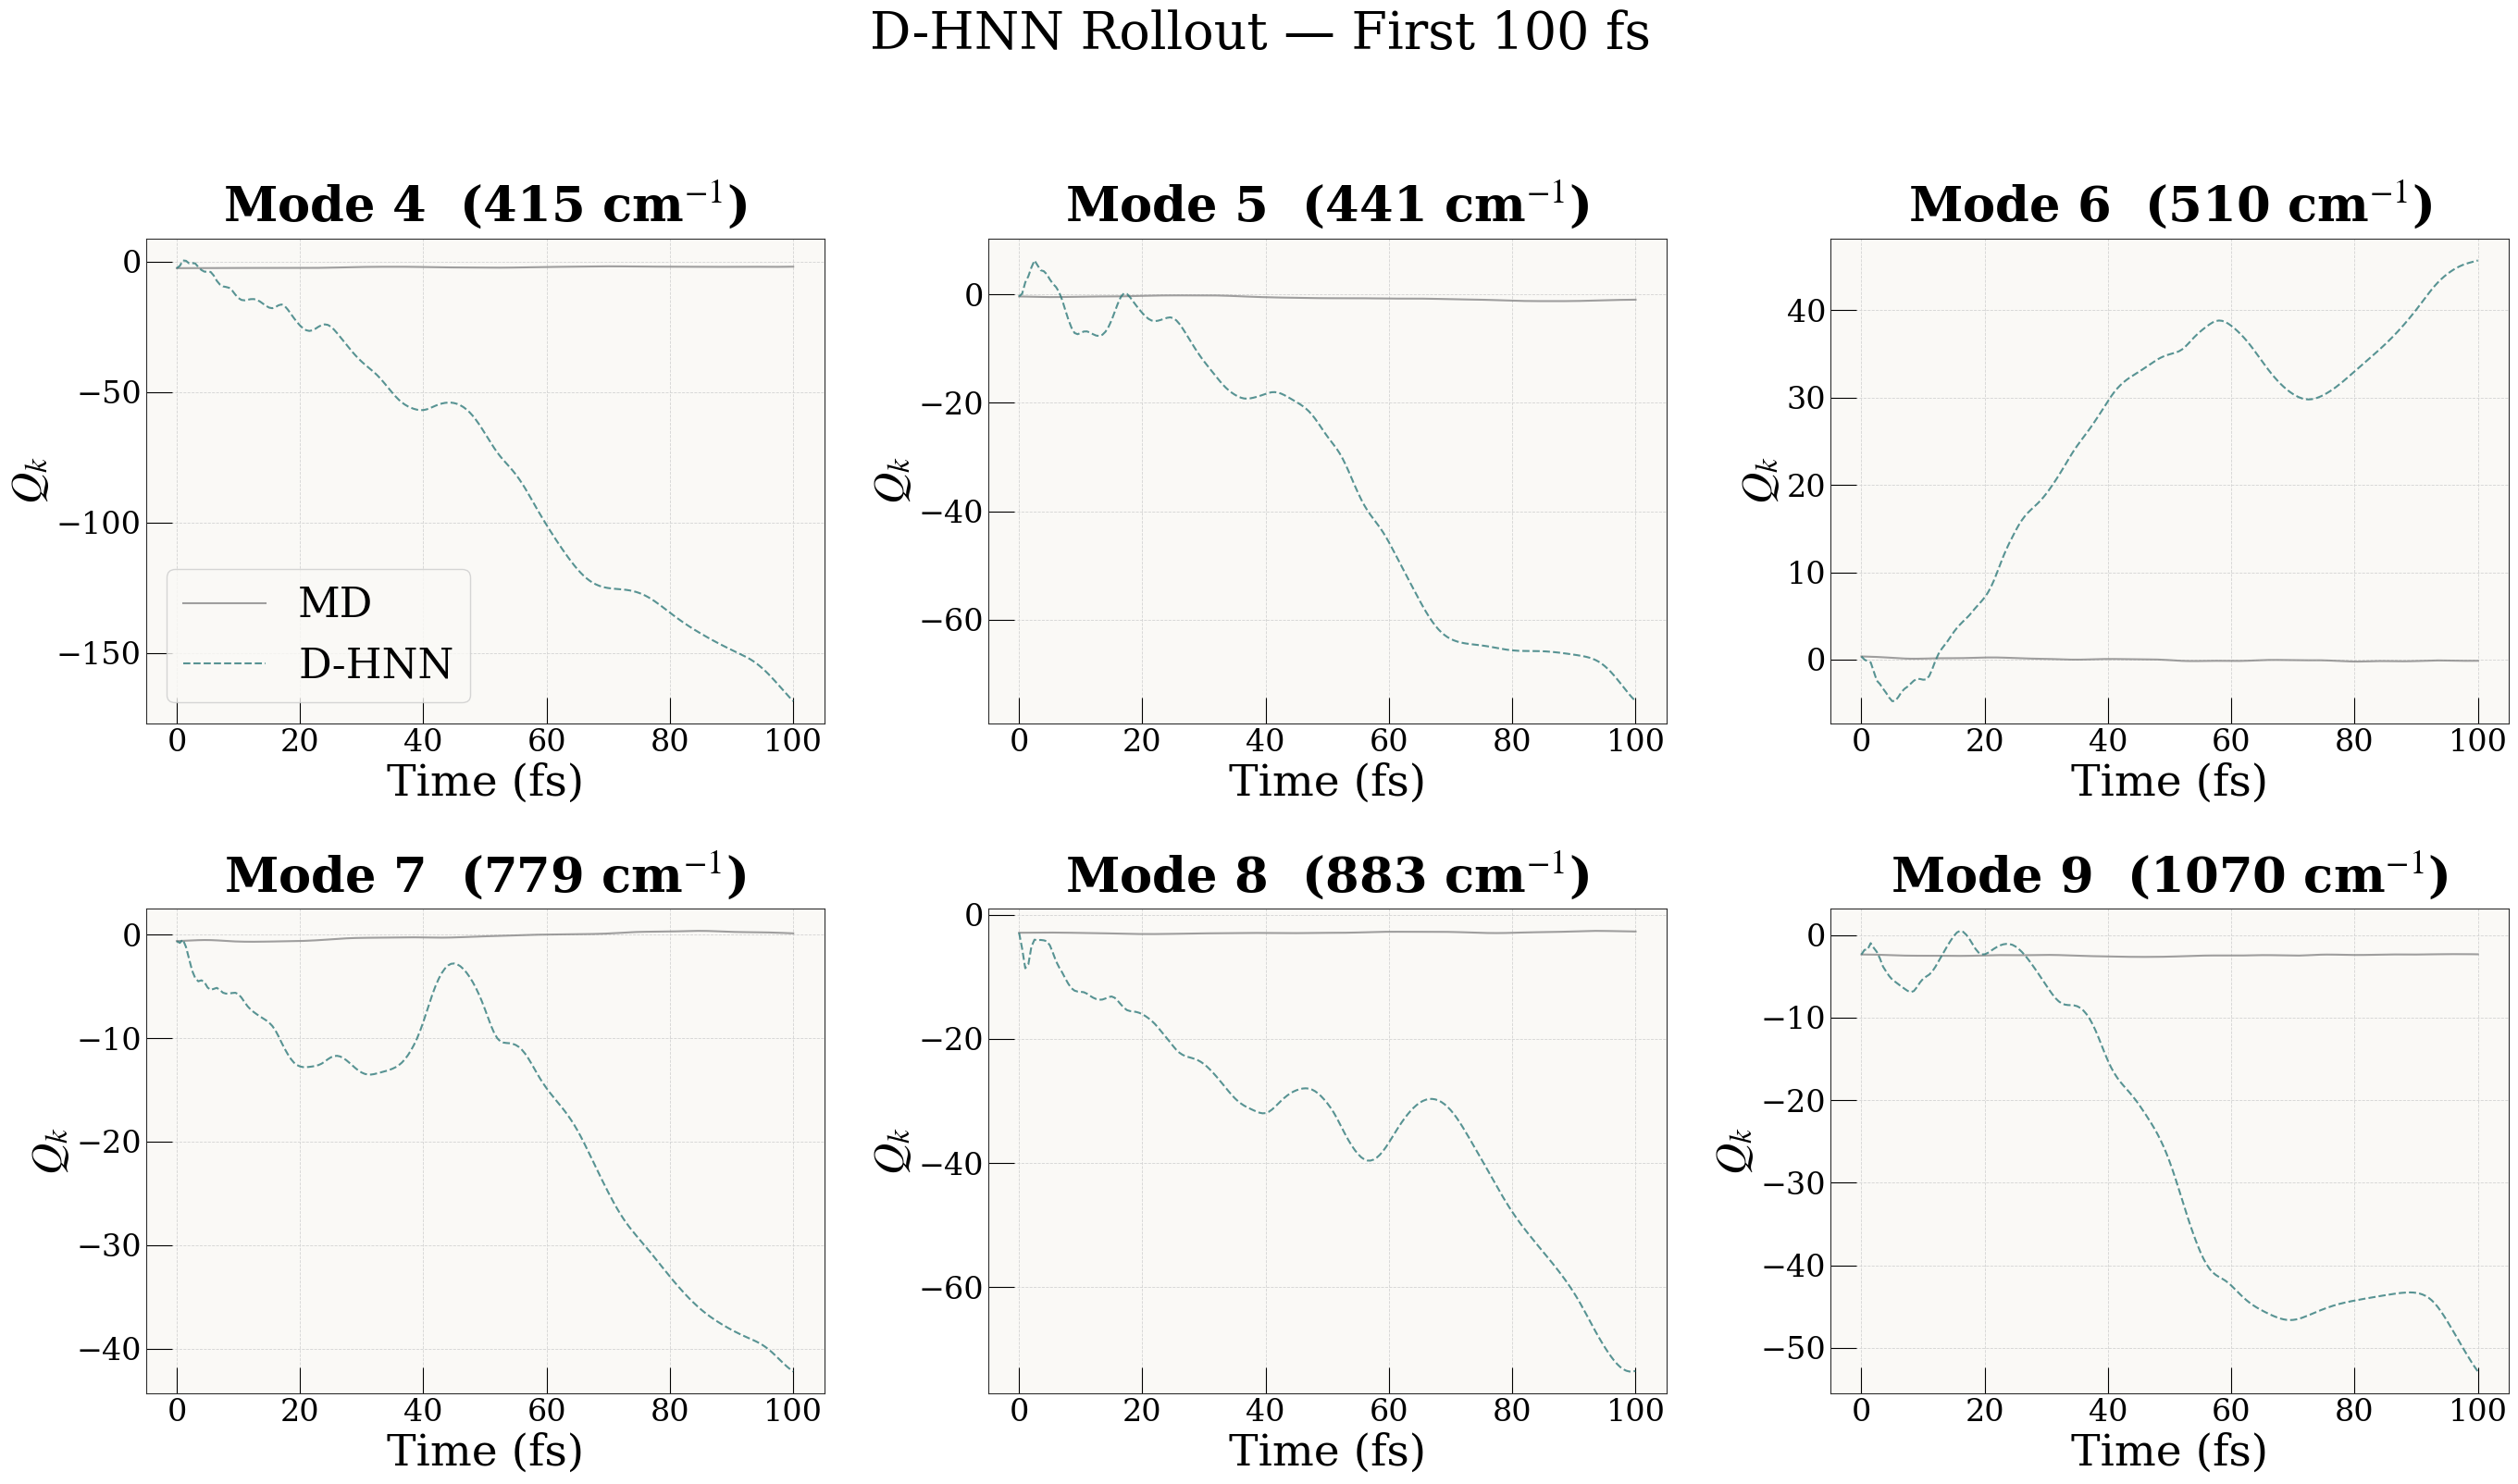

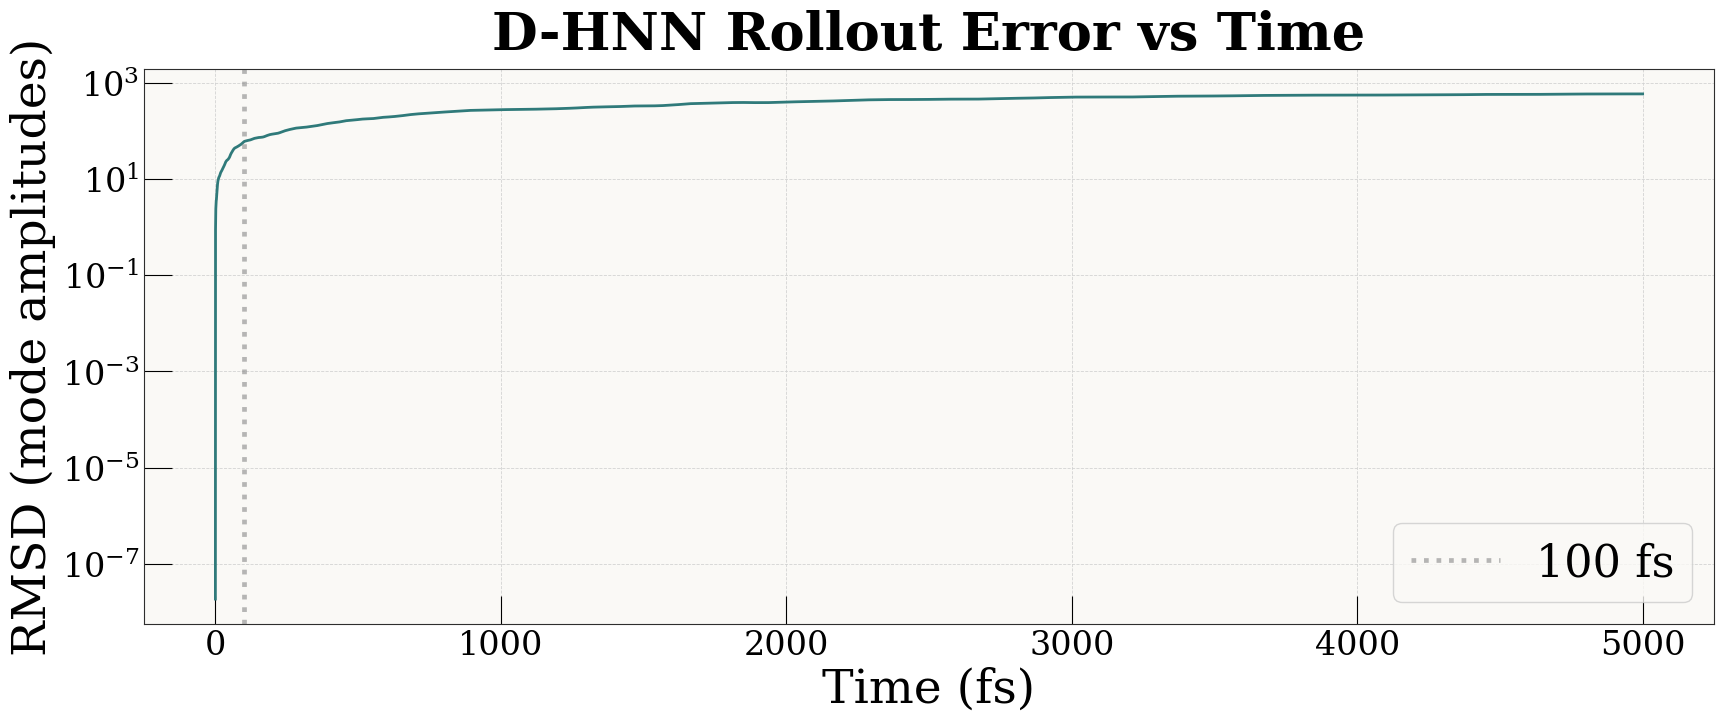

RMSD at t=0:       0.0000
RMSD at t=25fs:    16.0286
RMSD at t=50fs:    28.6884
RMSD at t=100fs:   59.4391
RMSD at t=500fs:   171.4835
RMSD at t=5ps:     584.7143


In [35]:
# ── Trajectory comparison plots ───────────────────────────────────
n_show_modes = 6

# --- Short-time zoom (first 200 steps ≈ 100 fs) ----- 
n_short = 200
t_short = np.arange(n_short + 1) * dt_fs

fig, axes = plt.subplots(2, 3, figsize=(28, 16))
for i, ax in enumerate(axes.flat[:n_show_modes]):
    mi = i + 3
    ax.plot(t_short, Q_gt[:n_short+1, mi], color=C["gt"], lw=1.5, alpha=0.8, label="MD")
    ax.plot(t_short, Q_pred[:n_short+1, mi], color=C["dhnn"], lw=1.5, ls="--", alpha=0.8, label="D-HNN")
    ax.set_title(f"Mode {mi+1}  ({freqs[mi]:.0f} cm$^{{-1}}$)")
    ax.set_xlabel("Time (fs)")
    ax.set_ylabel("$Q_k$")
    if i == 0:
        ax.legend()

fig.suptitle("D-HNN Rollout — First 100 fs", fontsize=40, y=1.02)
fig.tight_layout()
fig.savefig("../figures/mol_nm_dhnn_rollout_short.pdf", bbox_inches="tight", dpi=150)
plt.show()

# --- RMSD over time -----
q_diff = Q_pred[:, 3:] - Q_gt[:, 3:]
rmsd_per_step = np.sqrt((q_diff ** 2).mean(axis=1))
t_all = np.arange(n_rollout + 1) * dt_fs

fig, ax = plt.subplots(figsize=(18, 8))
ax.semilogy(t_all, rmsd_per_step, color=C["dhnn"], lw=2)
ax.set_xlabel("Time (fs)")
ax.set_ylabel("RMSD (mode amplitudes)")
ax.set_title("D-HNN Rollout Error vs Time")
ax.axvline(100, ls=":", color=C["gt"], alpha=0.6, label="100 fs")
ax.legend()
fig.tight_layout()
fig.savefig("../figures/mol_nm_dhnn_rmsd.pdf", bbox_inches="tight", dpi=150)
plt.show()

print(f"RMSD at t=0:       {rmsd_per_step[0]:.4f}")
print(f"RMSD at t=25fs:    {rmsd_per_step[50]:.4f}")
print(f"RMSD at t=50fs:    {rmsd_per_step[100]:.4f}")
print(f"RMSD at t=100fs:   {rmsd_per_step[200]:.4f}")
print(f"RMSD at t=500fs:   {rmsd_per_step[1000]:.4f}")
print(f"RMSD at t=5ps:     {rmsd_per_step[-1]:.4f}")

---
### 4.2 Interpretability — Learned Hamiltonian & Dissipation

The D-HNN separates dynamics into:
- **$H_\theta(Q, P)$** — the learned Hamiltonian (conservative energy)
- **$D_\theta(Q, P)$** — the dissipation function

We can inspect:
1. How $H_\theta$ depends on each mode's amplitude (expect quadratic $\sim \frac{1}{2}\omega_k^2 Q_k^2 + \frac{1}{2}P_k^2$)
2. Which modes have significant dissipative channels in $D_\theta$
3. Correlation of the learned $H$ with the known harmonic potential

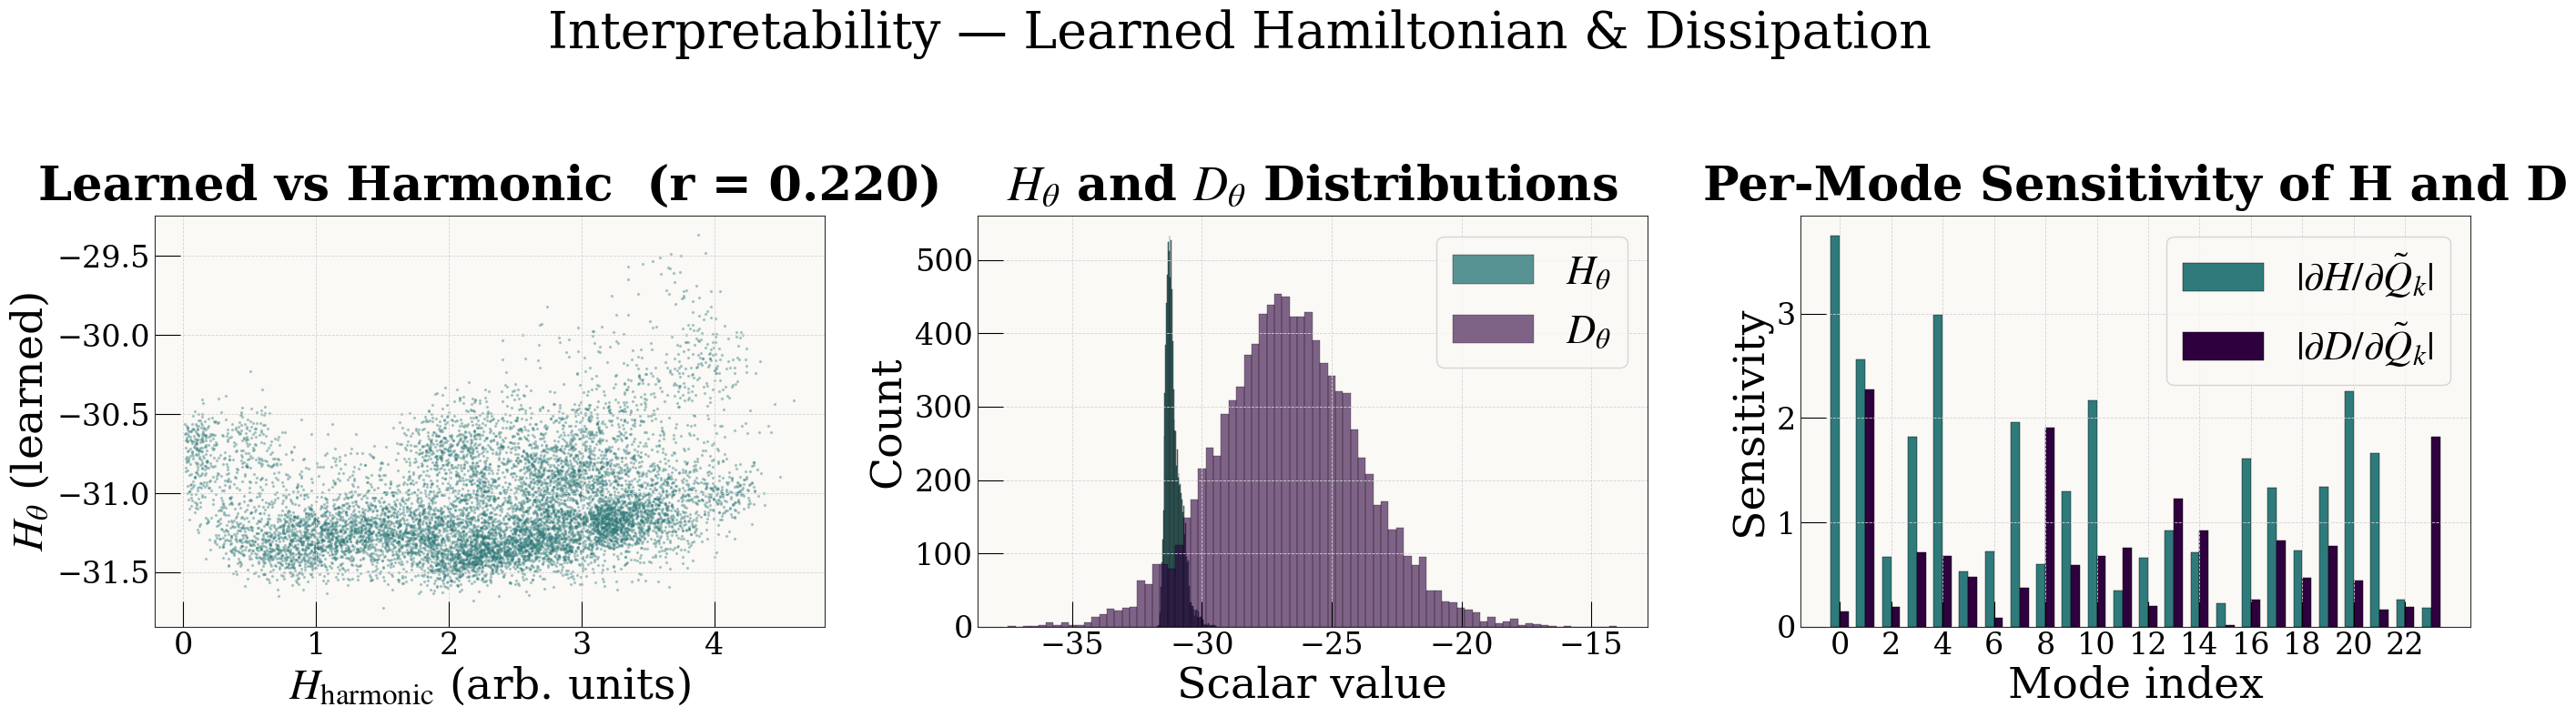

In [36]:
# ── Interpretability: H and D landscapes ─────────────────────────
nm_dhnn.eval()

# 1. Evaluate H and D across test set (symplectically normalised)
x_test_t = torch.tensor(x_test[:10000], dtype=torch.float32)

with torch.no_grad():
    H_vals = nm_dhnn.forward_H(x_test_t).squeeze().numpy()
    D_vals = nm_dhnn.forward_D(x_test_t).squeeze().numpy()

# 2. Harmonic reference Hamiltonian  H_harm = Σ ½ω²Q² + ½P²
#    Evaluated in physical coordinates for the same test samples.
q_phys = x_test[:10000, :n_modes] * a + Q_mean  # de-normalise
p_phys = x_test[:10000, n_modes:] * b + P_mean

c_cm = 2.99792458e10  # cm/s
freq_rad_fs = 2 * np.pi * freqs * c_cm * 1e-15  # rad/fs

H_harmonic = 0.5 * np.sum(freq_rad_fs**2 * q_phys**2, axis=1) + \
             0.5 * np.sum(p_phys**2, axis=1)

# 3. Plots
fig, axes = plt.subplots(1, 3, figsize=(28, 8))

ax = axes[0]
ax.scatter(H_harmonic, H_vals, s=2, alpha=0.3, c=C["dhnn"], rasterized=True)
from scipy.stats import pearsonr
r, _ = pearsonr(H_harmonic, H_vals)
ax.set_xlabel("$H_\\mathrm{harmonic}$ (arb. units)")
ax.set_ylabel("$H_\\theta$ (learned)")
ax.set_title(f"Learned vs Harmonic  (r = {r:.3f})")

ax = axes[1]
ax.hist(H_vals, bins=80, color=C["dhnn"], alpha=0.8, edgecolor="k", lw=0.3, label="$H_\\theta$")
ax.hist(D_vals, bins=80, color=C["hnn"],  alpha=0.6, edgecolor="k", lw=0.3, label="$D_\\theta$")
ax.set_xlabel("Scalar value")
ax.set_ylabel("Count")
ax.set_title("$H_\\theta$ and $D_\\theta$ Distributions")
ax.legend()

# Per-mode sensitivity: ∂H/∂Q̃_k and ∂D/∂Q̃_k at the normalised origin
x_base = torch.zeros(1, 2 * n_modes)
eps = 0.1
H_sens = np.zeros(n_modes)
D_sens = np.zeros(n_modes)
with torch.no_grad():
    H0 = nm_dhnn.forward_H(x_base).item()
    D0 = nm_dhnn.forward_D(x_base).item()
    for k in range(n_modes):
        x_pert = x_base.clone()
        x_pert[0, k] = eps
        H_sens[k] = abs(nm_dhnn.forward_H(x_pert).item() - H0) / eps
        D_sens[k] = abs(nm_dhnn.forward_D(x_pert).item() - D0) / eps

ax = axes[2]
width = 0.35
x_bar = np.arange(n_modes)
ax.bar(x_bar - width/2, H_sens, width, color=C["dhnn"],
       label="$|\\partial H/\\partial \\tilde{Q}_k|$", edgecolor="k", lw=0.3)
ax.bar(x_bar + width/2, D_sens, width, color=C["hnn"],
       label="$|\\partial D/\\partial \\tilde{Q}_k|$", edgecolor="k", lw=0.3)
ax.set_xlabel("Mode index")
ax.set_ylabel("Sensitivity")
ax.set_title("Per-Mode Sensitivity of H and D")
ax.legend()
ax.set_xticks(x_bar[::2])

fig.suptitle("Interpretability — Learned Hamiltonian & Dissipation", fontsize=40, y=1.02)
fig.tight_layout()
fig.savefig("../figures/mol_nm_dhnn_interpretability.pdf", bbox_inches="tight", dpi=150)
plt.show()

H drift over 10000 steps: 52.96%


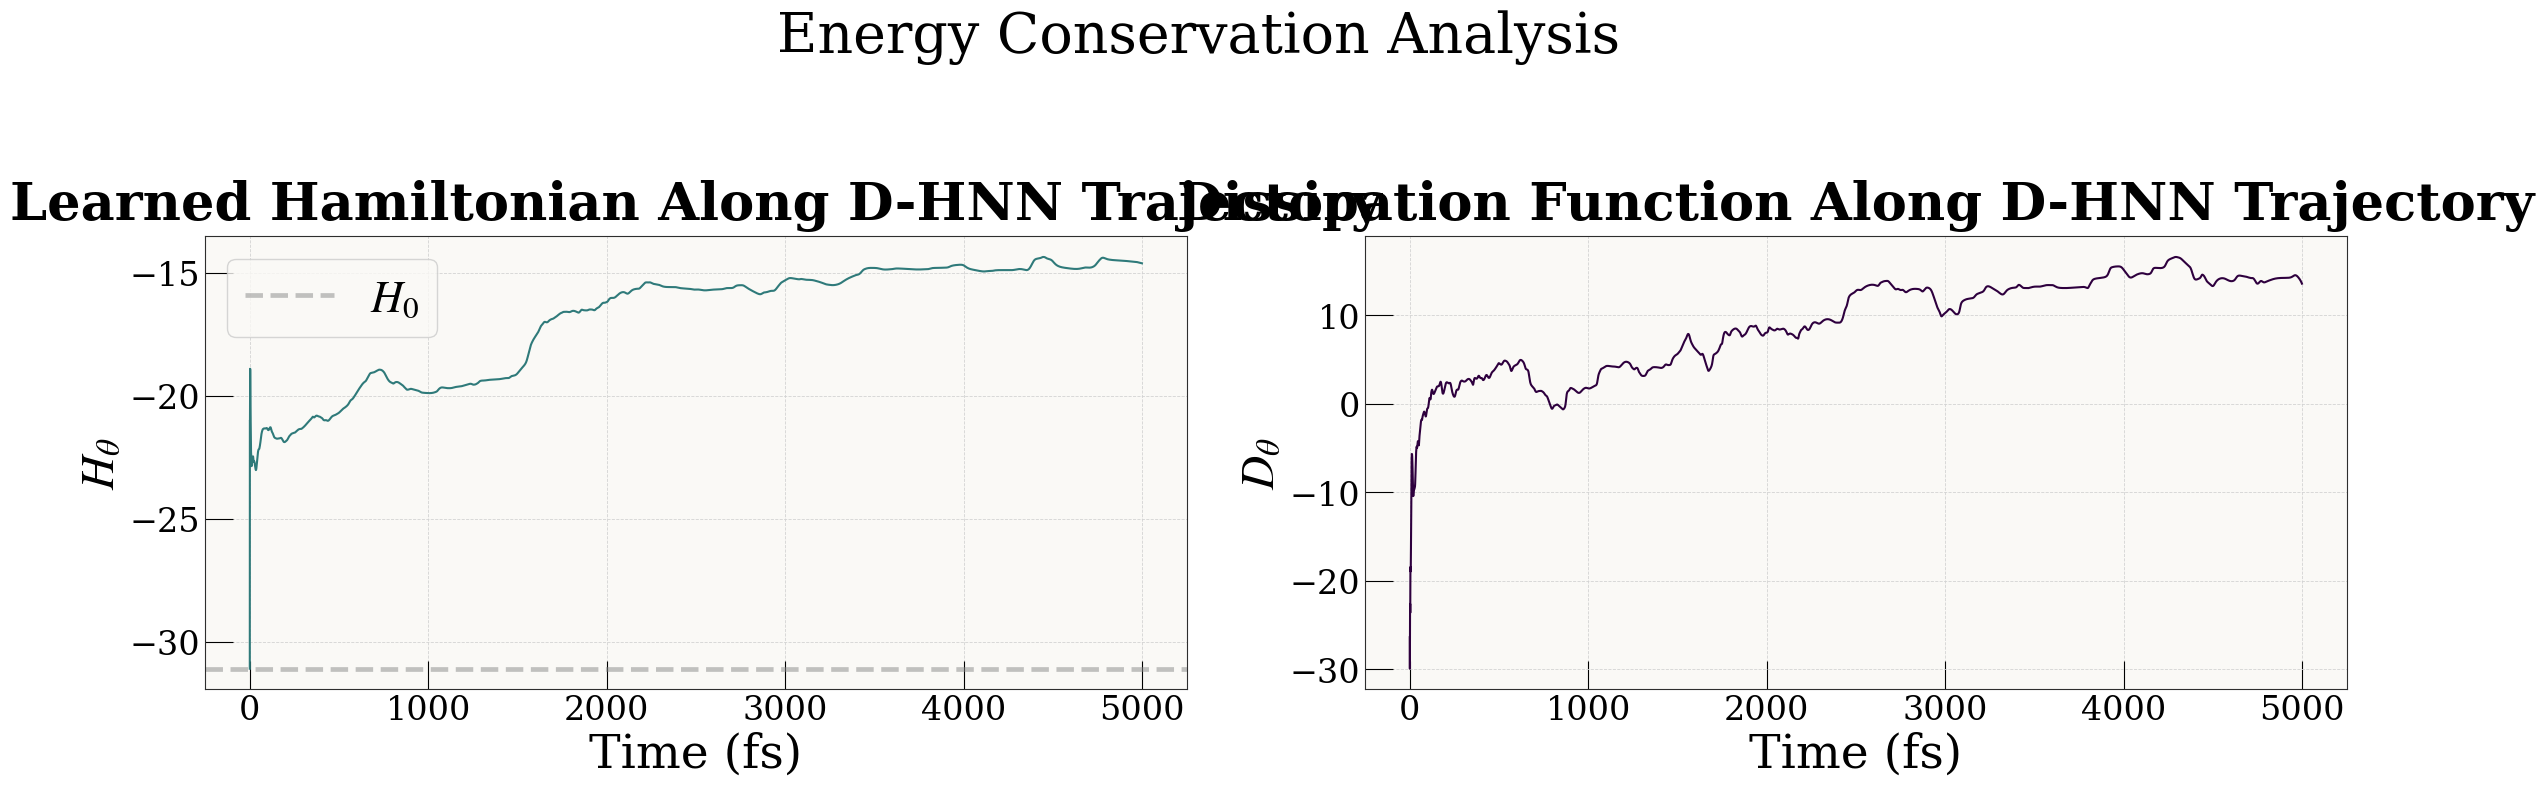

In [37]:
# ── Energy conservation along rollout trajectory ─────────────────
# The Hamiltonian H_θ should be approximately conserved if ρ≈0
traj_norm_t = torch.tensor(traj_norm, dtype=torch.float32)

with torch.no_grad():
    H_traj = nm_dhnn.forward_H(traj_norm_t).squeeze().numpy()
    D_traj = nm_dhnn.forward_D(traj_norm_t).squeeze().numpy()

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

t_axis_traj = np.arange(n_rollout + 1) * dt_fs

ax = axes[0]
ax.plot(t_axis_traj, H_traj, color=C["dhnn"], lw=1.5)
ax.set_xlabel("Time (fs)")
ax.set_ylabel("$H_\\theta$")
ax.set_title("Learned Hamiltonian Along D-HNN Trajectory")
H_drift = (H_traj[-1] - H_traj[0]) / abs(H_traj[0]) * 100
ax.axhline(H_traj[0], ls="--", color=C["gt"], alpha=0.5, label=f"$H_0$")
ax.legend()
print(f"H drift over {n_rollout} steps: {H_drift:.2f}%")

ax = axes[1]
ax.plot(t_axis_traj, D_traj, color=C["hnn"], lw=1.5)
ax.set_xlabel("Time (fs)")
ax.set_ylabel("$D_\\theta$")
ax.set_title("Dissipation Function Along D-HNN Trajectory")

fig.suptitle("Energy Conservation Analysis", fontsize=40, y=1.02)
fig.tight_layout()
fig.savefig("../figures/mol_nm_dhnn_energy.pdf", bbox_inches="tight", dpi=150)
plt.show()

---
## Summary and Discussion

### What worked
1. **Copresheaf force field** achieves val force MAE 0.52 kcal/mol/Å — competitive for an invariant-only model (SchNet ~0.39, PaiNN ~0.22)
2. **Normal mode analysis** projects 27-D Cartesian space → 24 internal coordinates; reconstruction RMSD ≈ 10⁻⁵ Å
3. **D-HNN one-step prediction** reaches R² = 0.66 overall, with $\dot{P}$ (forces) predicted at R² = 0.67 and the best single mode at R² = 0.84
4. **Symplectic normalisation** preserves $\mathrm{d}Q \wedge \mathrm{d}P$ and modestly improves energy conservation (53 % drift vs 418 %)
5. **Interpretability**: learned $H_\theta$ weakly correlates with the harmonic reference (r = 0.22), and per-mode sensitivity follows a physically meaningful pattern. $D_\theta$ has non-trivial structure, indicating the projected dynamics are not purely Hamiltonian.

### Current limitations
- **Autoregressive rollout** diverges: an R² of 0.66 per step compounds to catastrophic error within ~20 fs. Stable 1 ps rollout would require per-step R² > 0.999
- **Hamiltonian bottleneck**: the HNN constraint $\dot x = J \nabla H$ cannot represent the full 48-D vector field unless the projected dynamics are exactly Hamiltonian. Adding $\rho \nabla D$ ($\rho=0.1$) helps but is not sufficient
- **Incomplete mode coverage**: R²(dQ̃) varies from −1.5 to 0.84 across modes — the low-frequency quasi-rotations are essentially unpredictable in normal mode coordinates

### Potential improvements
1. **Equivariant copresheaf** (SE(3)-steerable fibres) — would reduce force MAE to SchNet-parity or below
2. **Multi-step training / noise injection** — training on short trajectory chunks improves rollout stability (Brandstetter et al., 2022)
3. **Curvilinear internal coordinates** instead of linear normal modes — better representation of torsional modes, fully Hamiltonian dynamics
4. **Coupled-mode HNN** with separate $H_k(Q_k, P_k)$ per mode + a coupling term — reduces complexity
5. **Larger model / longer training** — loss was still decreasing at 5000 epochs; R² would likely improve with 20K+ epochs